In [3]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gmaps
import os
import json 
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import urllib
from scipy.stats import linregress
import time

In [4]:
# File to Load
file_to_load = "Resources/BRFSS__Table_of_Overweight_and_Obesity__BMI_.csv"

# Read Obesity CSV and store into Pandas data frame
obesity_df_full = pd.read_csv(file_to_load)
obesity_df_full.head(10)

,Year,Locationabbr,Locationdesc,Class,Topic,Question,Response,Break_Out,Break_Out_Category,Sample_Size,...,Data_Value_Footnote,DataSource,ClassId,TopicId,LocationID,BreakoutID,BreakOutCategoryID,QuestionID,ResponseID,GeoLocation
0,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE02,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE07,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,...,NaN,BRFSS,CLASS14,TOPIC09,2,EDUCA2,CAT5,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),35-44,Age Group,151,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE03,CAT3,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME2,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
5,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Obese (BMI 30.0 - 99.8),65+,Age Group,261,...,NaN,BRFSS,CLASS14,TOPIC09,2,AGE09,CAT3,_BMI5CAT,RESP039,"(64.84507995700051, -147.72205903599973)"
6,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Less than $15,000",Household Income,49,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME1,CAT6,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"
7,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Normal Weight (BMI 18.5-24.9),"$25,000-$34,999",Household Income,48,...,NaN,BRFSS,CLASS14,TOPIC09,2,INCOME3,CAT6,_BMI5CAT,RESP041,"(64.84507995700051, -147.72205903599973)"
8,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Underweight (BMI 12.0-18.4),"American Indian or Alaskan Native, non-Hispanic",Race/Ethnicity,5,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE03,CAT4,_BMI5CAT,RESP042,"(64.84507995700051, -147.72205903599973)"
9,2019,AK,Alaska,Overweight and Obesity (BMI),BMI Categories,Weight classification by Body Mass Index (BMI)...,Overweight (BMI 25.0-29.9),"Other, non-Hispanic",Race/Ethnicity,19,...,Prevalence estimate not available if the unwei...,BRFSS,CLASS14,TOPIC09,2,RACE06,CAT4,_BMI5CAT,RESP040,"(64.84507995700051, -147.72205903599973)"


In [5]:
# Extract Columns that will be used in analysis
reduced_obesity_df = obesity_df_full.loc[:, ["Year", "Locationabbr", "Response", "Break_Out", "Break_Out_Category", 
                                             "Sample_Size", "BreakoutID", "GeoLocation"]]
reduced_obesity_df.head()



,Year,Locationabbr,Response,Break_Out,Break_Out_Category,Sample_Size,BreakoutID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [6]:
# Rename columns for clarity
reduced_obesity_df = reduced_obesity_df.rename(columns={"Locationabbr": "State", 
                                                        "Response": "BMI Range", "Break_Out": "Class", 
                                                        "Break_Out_Category": "Class Category", 
                                                        "Sample_Size": "Number of Respondents",
                                                        "BreakoutID": "Class ID"})

reduced_obesity_df

,Year,State,BMI Range,Class,Class Category,Number of Respondents,Class ID,GeoLocation
0,2019,AK,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,22,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,2,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,239,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,Overweight (BMI 25.0-29.9),35-44,Age Group,151,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,95,INCOME2,"(64.84507995700051, -147.72205903599973)"
...,...,...,...,...,...,...,...,...
47069,2011,WY,Underweight (BMI 12.0-18.4),"$35,000-$49,999",Household Income,13,INCOME4,"(43.235541343, -108.109830353)"
47070,2011,WY,Obese (BMI 30.0 - 99.8),"$50,000+",Household Income,689,INCOME5,"(43.235541343, -108.109830353)"
47071,2011,WY,Overweight (BMI 25.0-29.9),"$50,000+",Household Income,"1,116",INCOME5,"(43.235541343, -108.109830353)"
47072,2011,WY,Normal Weight (BMI 18.5-24.9),"$50,000+",Household Income,971,INCOME5,"(43.235541343, -108.109830353)"


In [5]:
# Reorder columns for clairty
reduced_obesity_df = reduced_obesity_df[['Year', 'State', 'Number of Respondents', 
                                         'BMI Range', 'Class', 'Class Category', 'Class ID', 'GeoLocation']]
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,GeoLocation
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,"(64.84507995700051, -147.72205903599973)"
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,"(64.84507995700051, -147.72205903599973)"
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,"(64.84507995700051, -147.72205903599973)"
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,"(64.84507995700051, -147.72205903599973)"
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,"(64.84507995700051, -147.72205903599973)"


In [2]:
# Split GeoLocation into lat and lng for loop
new_column = reduced_obesity_df["GeoLocation"].str.split(",", n = 1, expand = True) 
reduced_obesity_df["Lat"]= new_column[0] 
reduced_obesity_df["Lng"]= new_column[1] 
reduced_obesity_df.head()

NameError: name 'reduced_obesity_df' is not defined

In [7]:
# Remove unwanted characters from the Lat and Lng Columns
reduced_obesity_df['Lat'] = reduced_obesity_df['Lat'].str.replace('(', '')
reduced_obesity_df['Lng'] = reduced_obesity_df['Lng'].str.replace(')', '')

KeyError: 'Lat'

In [ ]:
# Remove Geolocation
reduced_obesity_df = reduced_obesity_df.drop(columns=['GeoLocation'])

In [8]:
# Remove commas from Number of Respondents
reduced_obesity_df['Number of Respondents'] = reduced_obesity_df['Number of Respondents'].str.replace(',', '')

In [9]:
# Convert Number of Respondents Columns to integer
reduced_obesity_df['Number of Respondents'] = pd.to_numeric(reduced_obesity_df['Number of Respondents'])
reduced_obesity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   47074 non-null  int64 
 1   State                  47074 non-null  object
 2   BMI Range              47074 non-null  object
 3   Class                  47074 non-null  object
 4   Class Category         47074 non-null  object
 5   Number of Respondents  47074 non-null  int64 
 6   Class ID               47074 non-null  object
 7   GeoLocation            47002 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.9+ MB


In [10]:
# Keep only most recent year (2019)
recent_df = reduced_obesity_df.loc[reduced_obesity_df['Year'] == 2019]

In [11]:
# Drop year column
recent_df = recent_df.drop(columns=['Year'])

In [12]:
# Keep only number of Respondents and BMI Range for state v. state comparison
recent_df_reduced = recent_df.loc[:, ["State", "Number of Respondents", "BMI Range"]]

In [13]:
# Display max rows
pd.set_option('display.max_rows', None)

In [22]:
# Display the total number of states
obesity_df_full["Locationabbr"].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD',
       'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'US', 'UT', 'UW', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'NJ',
       'VI'], dtype=object)

In [29]:
# Drop the US Rows
drop_us = recent_df_reduced.drop(recent_df_reduced.index[4680:4684])

In [33]:
# Drop the UW Rows
drop_uw = drop_us.drop(recent_df_reduced.index[4788:4791])

In [34]:
# Reset index and Rename DF
clean_state_df = drop_uw.reset_index(drop=True)

In [37]:
reduced_obesity_df["State"].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD',
       'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'US', 'UT', 'UW', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY', 'NJ',
       'VI'], dtype=object)

In [19]:
# Check new length of states (should be 52, 50 states plus PR and Guam)
new_total_states = len(clean_state_df["State"].unique())
new_total_states

52

In [20]:
# Display the total number of respondents
respondent_total = clean_state_df["Number of Respondents"].sum()
respondent_total

2231286

In [21]:
# Get sum of total respondents for each state
state_sum = clean_state_df.groupby('State')['Number of Respondents'].sum()

# Get sum of total overweight respondents for each state
overweight_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Overweight (BMI 25.0-29.9)'].groupby("State")["Number of Respondents"].sum()

# Find overweight rates for each state
overweight_rates = (overweight_sum / state_sum) * 100

# Get sum of total underweight respondents for each state
underweight_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Underweight (BMI 12.0-18.4)'].groupby("State")["Number of Respondents"].sum()

# Find underweight rates for each state
underweight_rates = (underweight_sum / state_sum) * 100

# Get sum of total obese respondents for each state
obesity_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Obese (BMI 30.0 - 99.8)'].groupby("State")["Number of Respondents"].sum()

# Find obesity rates for each state
obesity_rates = (obesity_sum / state_sum) * 100

# Get sum of total normalweight respondents for each state
normal_sum = clean_state_df.loc[clean_state_df["BMI Range"] == 'Normal Weight (BMI 18.5-24.9)'].groupby("State")["Number of Respondents"].sum()

# Find Obesity Rates for each state
normal_rates = (normal_sum / state_sum) * 100

In [22]:
# Create New Data Frame to hold the values

state_summary_df = pd.DataFrame({
                                "% Overweight": overweight_rates,
                                "% Underweight": underweight_rates,
                                "% Obese": obesity_rates,
                                "% Normal": normal_rates
                                                        })
state_summary_df.style.format({
                                "% Overweight":"{:,.2f}",
                                "% Underweight": "{:,.2f}",
                                "% Obese": "{:,.2f}",
                                "% Normal": "{:,.2f}"
                                   })

,% Overweight,% Underweight,% Obese,% Normal
State,,,,
AK,36.34,1.56,30.83,31.27
AL,35.22,1.96,35.99,26.84
AR,34.36,1.54,35.27,28.83
AZ,35.95,1.99,30.06,32.00
CA,37.18,1.71,27.05,34.05
CO,36.54,1.89,24.10,37.47
CT,37.97,1.69,28.13,32.21
DC,34.00,1.30,27.35,37.35
DE,35.34,1.67,35.53,27.46


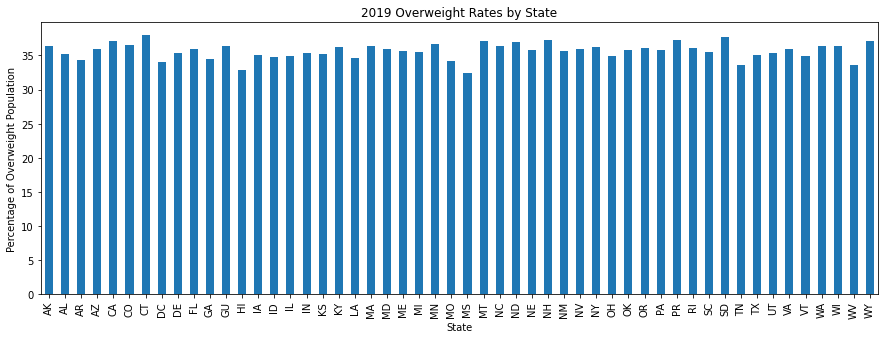

In [23]:
# Create Bar Graph Representing Overweight Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = overweight_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Overweight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Percentage of Overweight Population")
plt.savefig("Output_Data/Fig1.png")

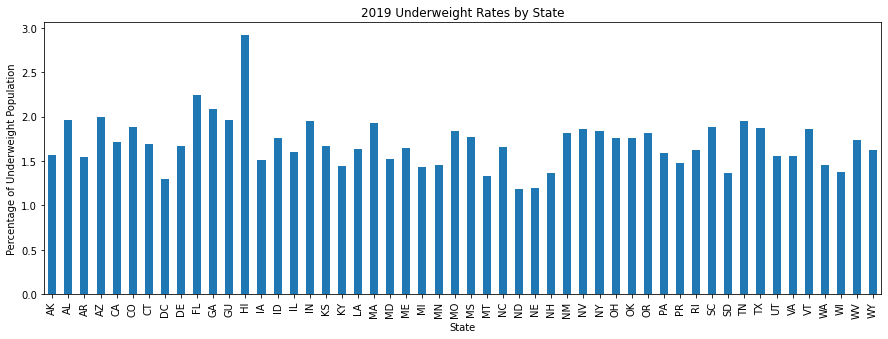

In [24]:
# Create Bar Graph Representing Underweight Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = underweight_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Underweight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Percentage of Underweight Population")
plt.savefig("Output_Data/Fig2.png")

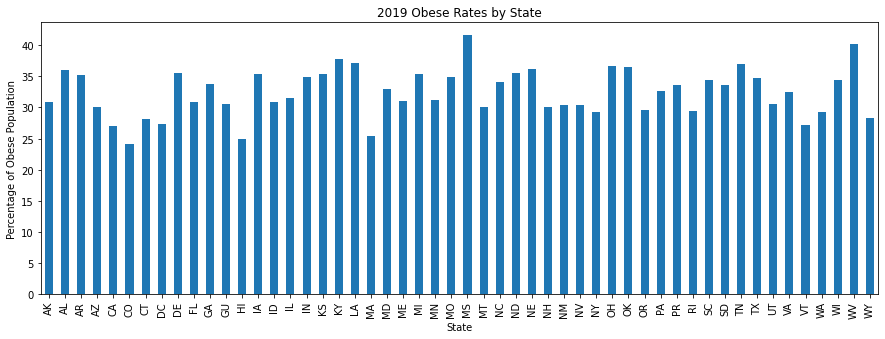

In [25]:
# Create Bar Graph Representing Overweight Rates
x_axis = reduced_obesity_df['State'].unique()
y_axis = obesity_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Obese Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Percentage of Obese Population")
plt.savefig("Output_Data/Fig3.png")

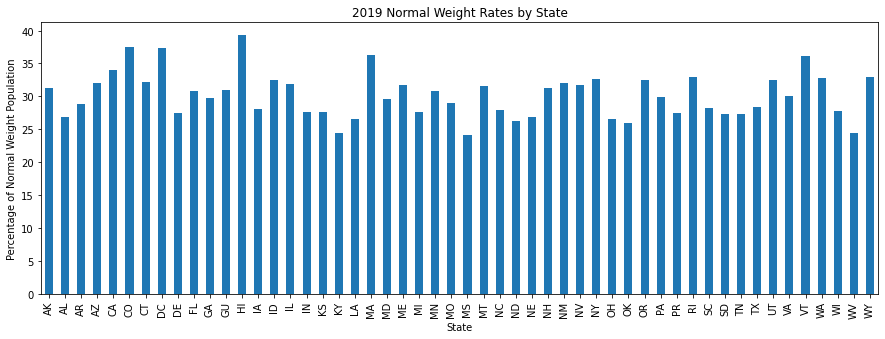

In [26]:
# Create Bar Graph Representing Normal Rates
x_axis = recent_df_reduced['State'].unique()
y_axis = normal_rates
state_obesity_bar = y_axis.plot(kind="bar", figsize=(15,5), title="2019 Normal Weight Rates by State")
state_obesity_bar.set_xlabel("State")
state_obesity_bar.set_ylabel("Percentage of Normal Weight Population")
plt.savefig("Output_Data/Fig4.png")

In [27]:
# Check Data
reduced_obesity_df.head()

,Year,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,Lat,Lng
0,2019,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,64.84507995700051,-147.72205903599973
1,2019,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,64.84507995700051,-147.72205903599973
2,2019,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,64.84507995700051,-147.72205903599973
3,2019,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,64.84507995700051,-147.72205903599973
4,2019,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,64.84507995700051,-147.72205903599973


In [28]:
# Keep only Maryland data
md_df = reduced_obesity_df.loc[reduced_obesity_df['State'] == 'MD']

In [29]:
# Drop state, lat, and lng columns
md_df_reduced_1 = md_df.drop(columns=['State', 'Lat', 'Lng'])

In [30]:
# Bug Fix 
md_df_reduced_1['BMI Range'] = md_df_reduced_1['BMI Range'].str.replace('bmi', 'BMI')

In [31]:
# Reset index and Rename DF
md_clean_df_1 = md_df_reduced_1.reset_index(drop=True)
md_clean_df_1.head()

,Year,Number of Respondents,BMI Range,Class,Class Category,Class ID
0,2019,23,Underweight (BMI 12.0-18.4),Less than H.S.,Education Attained,EDUCA1
1,2019,18,Underweight (BMI 12.0-18.4),"Less than $15,000",Household Income,INCOME1
2,2019,2446,Normal Weight (BMI 18.5-24.9),College graduate,Education Attained,EDUCA4
3,2019,317,Obese (BMI 30.0 - 99.8),Less than H.S.,Education Attained,EDUCA1
4,2019,3186,Overweight (BMI 25.0-29.9),"$50,000+",Household Income,INCOME5


In [32]:
md_clean_df_1['Class'].unique()

array(['Less than H.S.', 'Less than $15,000', 'College graduate',
       '$50,000+', 'Multiracial, non-Hispanic', 'White, non-Hispanic',
       '55-64', '18-24', '65+',
       'American Indian or Alaskan Native, non-Hispanic',
       'Other, non-Hispanic', '25-34', 'Hispanic', '$15,000-$24,999',
       '$25,000-$34,999', '35-44', '45-54', 'Overall',
       'Native Hawaiian or other Pacific Islander, non-Hispanic', 'Male',
       'Some post-H.S.', 'Asian, non-Hispanic', 'Female',
       'Black, non-Hispanic', '$35,000-$49,999', 'H.S. or G.E.D.'],
      dtype=object)

In [33]:
# Get sum of total respondents for each year
md_year_sum = md_clean_df_1.groupby('Year')['Number of Respondents'].sum()

# Get sum of obese respondents for each year
md_obesity_sum = md_clean_df_1.loc[md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)'].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for each year
md_obesity_rates = (md_obesity_sum / md_year_sum) * 100

In [34]:
# Sort Values to Start with 2011
md_clean_df_1_ascending = md_clean_df_1.sort_values("Year", ascending=True)

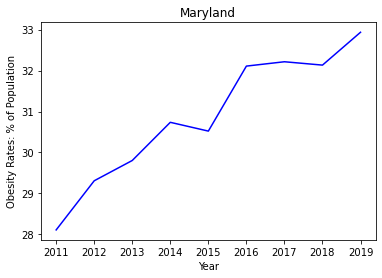

In [35]:
# Plot Maryland obesity rates since 2011
x_values_md_line = md_clean_df_1_ascending['Year'].unique()
y_values_md_line = md_obesity_rates 
md_plot = plt.plot(x_values_md_line, y_values_md_line, color="blue") 
plt.title("Maryland")
plt.xlabel("Year")
plt.ylabel("Obesity Rates: % of Population")
plt.savefig("Output_Data/Fig5.png")

In [36]:
# Get sum of md black respondents for each year
md_black_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == 'Black, non-Hispanic'].groupby("Year")["Number of Respondents"].sum()

# Find sum of md black obese respondents each year
md_black_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == 'Black, non-Hispanic')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for each year
md_black_obesity_rates = (md_black_obese / md_black_sum) * 100

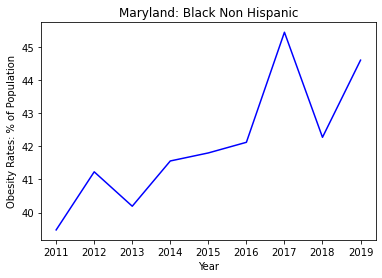

In [37]:
# Plot Maryland black obesity rates since 2011
x_values_md_line = md_clean_df_1_ascending['Year'].unique()
y_values_black_line = md_black_obesity_rates
md_black_plot = plt.plot(x_values_md_line, y_values_black_line, color="blue") 
plt.title("Maryland: Black Non Hispanic")
plt.xlabel("Year")
plt.ylabel("Obesity Rates: % of Population")
plt.savefig("Output_Data/Fig6.png")

In [38]:
# Get sum of md low income respondents for each year
md_low_income_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == 'Less than $15,000'].groupby("Year")["Number of Respondents"].sum()

# Find sum of md low income respondents each year
md_low_income_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == 'Less than $15,000')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for each year
md_low_income_obesity_rates = (md_low_income_obese / md_low_income_sum) * 100

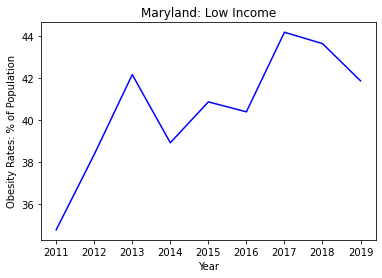

In [39]:
# Plot Maryland low income obesity rates since 2011
x_values_md_line = md_clean_df_1_ascending['Year'].unique()
y_values_low_income_line = md_low_income_obesity_rates
md__low_income_plot = plt.plot(x_values_md_line, y_values_low_income_line, color="blue") 
plt.title("Maryland: Low Income")
plt.xlabel("Year")
plt.ylabel("Obesity Rates: % of Population")
plt.savefig("Output_Data/Fig7.png")

In [40]:
# Get sum of md low education respondents for each year
md_low_ed_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == 'Less than H.S.'].groupby("Year")["Number of Respondents"].sum()

# Find sum of md black obese respondents each year
md_low_ed_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == 'Less than H.S.')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for each year
md_low_ed_obesity_rates = (md_low_ed_obese / md_low_ed_sum) * 100

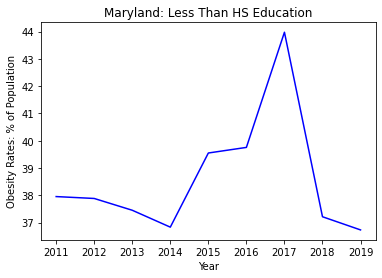

In [41]:
# Plot Maryland low education obesity rates since 2011
x_values_md_line = md_clean_df_1_ascending['Year'].unique()
y_values_low_education_line = md_low_ed_obesity_rates
md_low_ed_plot = plt.plot(x_values_md_line, y_values_low_education_line, color="blue") 
plt.title("Maryland: Less Than HS Education")
plt.xlabel("Year")
plt.ylabel("Obesity Rates: % of Population")
plt.savefig("Output_Data/Fig8.png")

In [42]:
# Get sum of md young adult respondents for each year
md_young_adult_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == '18-24'].groupby("Year")["Number of Respondents"].sum()

# Find sum of md young adult obese respondents each year
md_young_adult_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == '18-24')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for each year
md_young_adult_obesity_rates = (md_young_adult_obese / md_young_adult_sum ) * 100

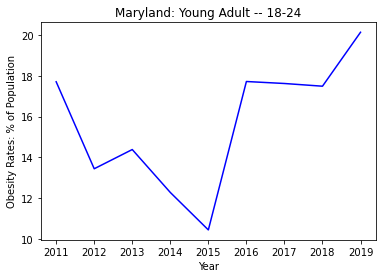

In [43]:
# Plot Maryland young adult obesity rates since 2011
x_values_md_line = md_clean_df_1_ascending['Year'].unique()
y_values_young_adult_line = md_young_adult_obesity_rates
md_young_adult_plot = plt.plot(x_values_md_line, y_values_young_adult_line, color="blue") 
plt.title("Maryland: Young Adult -- 18-24")
plt.xlabel("Year")
plt.ylabel("Obesity Rates: % of Population")
plt.savefig("Output_Data/Fig9.png")

In [44]:
# Get sum of total male respondents for each year
md_male_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == 'Male'].groupby("Year")["Number of Respondents"].sum()

# Find sum of male obese respondents each year
md_male_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == 'Male')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for males for each year
md_male_obesity_rates = (md_male_obese / md_male_sum) * 100

# Get sum of female respondents for each year
md_female_sum = md_clean_df_1.loc[md_clean_df_1["Class"] == 'Female'].groupby("Year")["Number of Respondents"].sum()

# Find sum of female obese respondents each year
md_female_obese = md_clean_df_1.loc[(md_clean_df_1["BMI Range"] == 'Obese (BMI 30.0 - 99.8)') & (md_clean_df_1["Class"] == 'Female')].groupby("Year")["Number of Respondents"].sum()

# Get obesity rates for females for each year
md_female_obesity_rates = (md_female_obese / md_female_sum) * 100

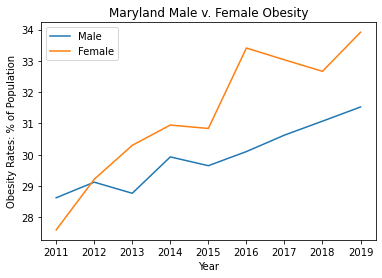

<Figure size 432x288 with 0 Axes>

In [45]:
# Plot Male v. Female Obesity Rates since 2011
# line 1 points
x1 = x_values_md_line 
y1 = md_male_obesity_rates
plt.plot(x1, y1, label = "Male")
# line 2 points
x2 = x_values_md_line 
y2 = md_female_obesity_rates
# plotting the line 2 points 
plt.plot(x2, y2, label = "Female")
plt.xlabel('Year')
# Set the y axis label of the current axis.
plt.ylabel('Obesity Rates: % of Population')
# Set a title of the current axes.
plt.title('Maryland Male v. Female Obesity')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
plt.savefig("Output_Data/Fig10.png")

In [92]:
recent_df.head()

,State,Number of Respondents,BMI Range,Class,Class Category,Class ID,Lat,Lng
0,AK,22,Overweight (BMI 25.0-29.9),"Black, non-Hispanic",Race/Ethnicity,RACE02,64.84507995700051,-147.72205903599973
1,AK,2,Underweight (BMI 12.0-18.4),"Multiracial, non-Hispanic",Race/Ethnicity,RACE07,64.84507995700051,-147.72205903599973
2,AK,239,Obese (BMI 30.0 - 99.8),H.S. or G.E.D.,Education Attained,EDUCA2,64.84507995700051,-147.72205903599973
3,AK,151,Overweight (BMI 25.0-29.9),35-44,Age Group,AGE03,64.84507995700051,-147.72205903599973
4,AK,95,Normal Weight (BMI 18.5-24.9),"$15,000-$24,999",Household Income,INCOME2,64.84507995700051,-147.72205903599973


In [1]:
recent_2_df = reduced_obesity_df.loc[reduced_obesity_df['State'] != 'US']

NameError: name 'reduced_obesity_df' is not defined

In [80]:
location_df_2 = pd.DataFrame({"State": recent_df['State'].unique().tolist(),
                            "Lat": recent_df['Lat'].unique().tolist(),
                            "Lng": recent_df['Lat'].unique().tolist()
                                                })
location_df_2

ValueError: arrays must all be same length

In [85]:
# location_df.dropna();